# Second Attempt at Titanic Data Set: Emphasis Cleaning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


## 1) Load Data

In [4]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2) Pre-process Data - determine how to munge

In [8]:
pd.crosstab(df['Pclass'], df['Embarked'], margins=True)

Embarked,C,Q,S,All
Pclass,,,,
1,85,2,127,214
2,17,3,164,184
3,66,72,353,491
All,168,77,644,889


### 2a) Missing Data

In [264]:
NE = len(df)
pct_missing = pd.Series()
missing = pd.DataFrame()

for i in df.columns:        
        missing[i] = pd.isnull(df[i])
        pct_missing[i] = len(df[pd.isnull(df[i])])/NE

print(pct_missing)
print(set(df['Embarked']))

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
{nan, 'S', 'Q', 'C'}


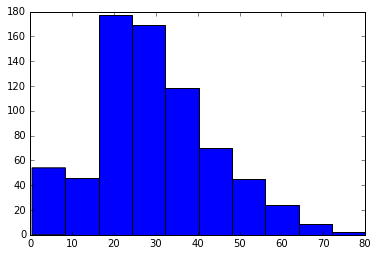

In [265]:
#Need to impute age (what does this distribution look like) and embarked (use stratified)
#Is Cabin worth keeping?

%matplotlib inline

#AGE
plt.figure()
n, bins, patches = plt.hist(df.loc[~missing['Age'],'Age'])
#Use strategy 'Normal' - though it's not great

#Embarked - Use strategy 'stratified'

#Cabin - drop

### Main Functions for Pre-processing data

In [280]:
### SEE MUNGE DATA FOR OUTLINE
def munge_data(df, bTrain=True, bSurname=False, bTitle=False, 
              name_cols=[], bTicketAlph=False):

    Y = df['Survived']
    X = df.drop(['PassengerId', 'Survived'], axis=1)
    
    #TODO CANT IMPUTE BEFORE DIGITIZING!!!
    #IMPUTE AGE & EMBARKED
    X['Age'] = impute_data(X['Age'], strategy='Normal')
    X['Embarked'] = impute_data(X['Embarked'], strategy='Stratified')    

    #DIGITIZE SEX
    X.loc[X['Sex']=='male', 'Sex'] = float(1)
    X.loc[X['Sex']=='female', 'Sex'] = float(0)
    X['Sex'] = X['Sex'].astype(float)
    
    #DIGITIZE EMBARKED
    X['Embarked_Q'] = (X['Embarked']=='Q').astype(float)
    X['Embarked_S'] = (X['Embarked']=='S').astype(float)
    X.drop('Embarked', axis=1, inplace=True)
    
    #DROP CABIN
    X = X.drop('Cabin', axis=1)
    
    #If testing, ensure new X variable has same categorical columns as training set
    if (bTrain==False):
        for i in name_cols:
            X[i]=0
            
    #PROCESS NAME (Title, Surname)
    X, name_cols = process_name(X, name_cols, bTrain=bTrain, 
                                    bSurname=bSurname, bTitle=bTitle)
    
    #PROCESS TICKET (Alph, numeric)
    X, name_cols = process_ticket(X, name_cols, bTrain=bTrain, bTicketAlph=bTicketAlph)    
    
    return X,Y,name_cols

In [281]:
def impute_data(col,strategy):
    col = pd.Series(col)
    m_idxs = list(col[pd.isnull(col)].index)
        
    if strategy == 'Stratified':
        #below - a series of unique non-null values from col
        col_nonull = pd.Series(list(set(col[~pd.isnull(col)])))
        NEx = len(col_nonull)
        probs = [sum(col==i)/NEx for i in col_nonull]
        csprobs = np.cumsum(probs)
        r = np.random.rand(len(m_idxs),1)
        for i in range(0,len(m_idxs)):
            col[m_idxs[i]] = col_nonull[csprobs>r[i]].iloc[0]
        return col
    
    if strategy == 'Mean':
        col[m_idxs] = col[~pd.isnull(col)].mean()
    
    if strategy == 'Median':
        col[m_idxs] = col[~pd.isnull(col)].median()
        
    if strategy == 'Normal':
        mu = col[~pd.isnull(col)].mean()
        sig = col[~pd.isnull(col)].std()
        col[m_idxs] = mu + sig*np.random.randn(len(m_idxs))
        return col
    
    if strategy == 'Exponential': #Shifts by min
        mu = (col[~pd.isnull(col)]-min(col[~pd.isnull(col)])).mean()
        col[m_idxs] = min(col[~pd.isnull(col)]) + np.random.exponential(scale=mu, size=(len(m_idxs)))
        return col

In [282]:
def process_name(X,name_cols,bTrain=True, bTitle=False, bSurname=False):
    '''
    X = process_name(X, name_cols, bTrain=True, bTitle=False, bSurname=False)
    Adds binarized name fields for surname and title to the returned df X. 
    
    Also requires the list of names of categories in name_cols
    
    Optional input 
        -boolean variable bTrain (def=True) determines whether in training or test phase
        -boolean variable bTitle (def=False)
        -boolean variable bSurname (def=False)

    
    Strategy is to 
      1) Extract SURNAME and TITLE from text that is formatted
         SURNAME, TITLE. FIRSTNAME
         NOTE: if opts contains booleans that determine whether this
         actually performed
      2) Use Pandas get_dummies to binarize this information
      3) Drop original Name column
    '''
    
    Surnames = X['Name'].str.split(',', expand=True)
    Titles = Surnames[1].str.split('.', expand=True)      
    
    if (bSurname):
        if (bTrain):
            surname_df = pd.get_dummies(Surnames[0])
            name_cols = name_cols + list(surname_df.columns)
            X = pd.concat([X, surname_df], axis=1)
        else:
            X = extract_categorical(X, name_cols, Surnames[0])
    
    if (bTitle):
        if (bTrain):
            title_df = pd.get_dummies(Titles[0])
            name_cols = name_cols + list(title_df.columns)
            X = pd.concat([X, title_df], axis=1)
        else:
            X = extract_categorical(X, name_cols, Titles[0])

                    
    X.drop('Name', axis=1, inplace=True)
    return X, name_cols

In [283]:
def process_ticket(X,name_cols,bTrain=True, bTicketAlph=False):
    '''
    X = process_ticket(X, name_cols, bTrain=True, bAlph=False, bNum=False)
    Adds binarized name fields for alpha and numeric part of the ticket to the returned df X. 
    
    Also requires the list of names of categories in name_cols
    
    Optional input 
    
    Options variable, opts, contains
        -boolean variable bTrain (def=True) determines whether in training or test phase
        -boolean variable bAlph (def=False) determines whether to get Alpha-part of Ticket
        -boolean variable bNum (def=False) determines whether to get Num-part of Ticket

    
    '''
    
    
    
    #Strip Numeric and String portions of Ticket
    withStr = X['Ticket'].str.contains("[a-zA-Z]")
    X['Ticket-Num']=None
        
    #Numeric only portions
    X.loc[~withStr, 'Ticket-Num'] = X.loc[~withStr, 'Ticket'].astype(float)
    
    #Numeric AND Alph
    A_Ticket = pd.DataFrame(X.loc[withStr, 'Ticket'].str.extract("([0-9]+$)", expand=True))

    ##### IMPUTING Tickets without number as 0 #####
    A_Ticket.loc[A_Ticket[0]=='',0]=0
    A_Ticket.loc[A_Ticket[0]=='.',0]=0
    A_Ticket.loc[pd.isnull(A_Ticket[0])]=0
    X.loc[withStr, 'Ticket-Num'] = A_Ticket[0].astype(float)

    #Ticket Alph
    A_Ticket = pd.DataFrame(X['Ticket'].str.extract("(.*\s)", expand=True))
    #A_Ticket = pd.DataFrame(X['Ticket'].str.split())
    #print(A_Ticket)
    A_Ticket[pd.isnull(A_Ticket[0])] = 'NULL-Ticket'
    if(bTicketAlph):
        if (bTrain):
            ticket_df = pd.get_dummies(A_Ticket[0])
            name_cols = name_cols + list(ticket_df.columns)
            X = pd.concat([X, ticket_df], axis=1)
        else:
            X = extract_categorical(X, name_cols, A_Ticket[0])

    
    X.drop('Ticket', axis=1, inplace=True)
    return X, name_cols

In [284]:
def extract_categorical(X, categories, Cats_New):
    for i in Cats_New.index:
        if Cats_New[i] in categories:
            X.loc[i,Cats_New[i]] = 1

    return X

### Tests for Pre-processing Functions - Sanity checks

In [285]:
def test_impute_data():
    #Test stratification-should impute mostly ones but sometimes 0
    bFailed=False
    NRuns = 100
    col = [1, np.nan, 1, np.nan, 1, 1, 1, 1, 1, 0]
    new_col = [0,0,0,0,0,0,0,0,0,0]
    
    new_col = [impute_data(col, strategy='Stratified') for i in range(0,NRuns)]
    new_col = np.mean(np.array(new_col), axis=1)
    
    p = 7/8
    SEM = np.sqrt(p*(1-p))
    if ((abs(new_col[1]-(7/8))>SEM) | (abs(new_col[3]-(7/8))>SEM)):
        print('test_impute_data:Stratified_test FAILED!!!')
        print('new_col[1]', new_col[1], 'Expected to be within', 2*SEM, 'of', p)
        print('new_col[3]', new_col[3], 'Expected to be within', 2*SEM, 'of', p)
        bFailed=True
    
    #Test Normal imputation
    mu = -5
    sig = 10
    col = mu + sig*np.random.randn(NRuns)
    col[:10] = np.nan
    new_col = impute_data(col, strategy='Normal')
    
    SEM = sig/np.sqrt(NRuns)
    if ((abs(np.mean(new_col)-mu)>3*SEM)|(abs(np.std(new_col)-sig)>2*SEM)):
        print('test_impute_data:Normal_test FAILED!!!')
        print('mu', np.mean(new_col), 'Expected to be within', 3*SEM, 'of', mu)
        print('sig', np.std(new_col), 'Expected to be within', 2*SEM, 'of', sig)
        bFailed=True
        
    return bFailed
   

In [286]:
def test_process_name():
    bFailed=False
    
    X_test = pd.DataFrame()
    X_test['Name'] = ['Einstein, Dr. Albert', 'Planck, Mr. Max', 'Hubbel, Mrs. Seesfar', 
                          'Hilbert, Dr. David', 'Einstein, Ms. AlsoBadHair']
    #Test Titles
    X_out, name_cols = process_name(X_test, [], bTitle=True, bTrain=True)
    X_expected_title = sorted([' Dr', ' Mr', ' Mrs', ' Ms']) #stipping keeps white space
    if not np.array_equal(list(X_out.columns), X_expected_title):
        print('test_process_name:Title_test: FAILED!!!')
        print('Out columns', list(X_out.columns), 'Expected', X_expected_title)
        bFailed=True
        
    
    
    
    #Test Surnames
    X_out, name_cols = process_name(X_test, [],bSurname=True, bTrain=True)
    X_expected_surname = sorted(['Einstein', 'Hilbert', 'Hubbel','Planck']) #NOTE: get_dummies alphabetizes
    if not np.array_equal(name_cols,X_expected_surname):
        print('test_process_name:Surname_test FAILED!!!')
        print('Out columns', list(X_out.columns), 'Expected', X_expected_surname)
        print(X_test['Name'])
        bFailed=True
        
    
    
    
    #Test Training Phase
    X_out, name_cols = process_name(X_test, [],bTitle=True, bSurname=True, bTrain=True)
    X_expected = [[1,0,0,0,1,0,0,0], [0,0,0,1,0,1,0,0], [0,0,1,0,0,0,1,0], 
                  [0,1,0,0,1,0,0,0], [1,0,0,0,0,0,0,1]]
    names_expected = X_expected_surname + X_expected_title
    if ((not np.array_equal(X_out.values,X_expected)) | (not np.array_equal(name_cols,names_expected))):
        print('test_process_name:Training_test FAILED!!!')
        print('Out names', list(name_cols), 'Expected', names_expected)
        print('Out X', X_out.values, 'Expected', X_expected)
        bFailed=True
    
    
    
    
    #Test Testing Phase
    X_out, name_cols = process_name(X_test, [],bTitle=True, bSurname=True, bTrain=True)
    X_test['Name'] = ['Heisenberg, Dr. Albert', 'Schrodinger, Mr. Max', 'Hubbel, Dr. Seesfar', 
                          'Hilbert, Ms. David', 'Einstein, Mr. AlsoBadHair']
    #Adding new 0 cols
    for i in name_cols:
        X_test[i] = 0
        
    X_out, name_cols = process_name(X_test, name_cols, bTitle=True, bSurname=True, bTrain=False)
    X_expected = [[0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,1,0,1,0,0,0], 
                  [0,1,0,0,0,0,0,1], [1,0,0,0,0,1,0,0]]
    if not np.array_equal(X_out.values,X_expected):
        print('test_process_name:Testing_test FAILED!!!')
        print('Out X', X_out.values, 'Expected', X_expected)
        bFailed=True    
    
    return bFailed

In [287]:
def test_process_ticket():
    bFailed=False
    
    X_test = pd.DataFrame()
    X_test['Ticket'] = ['A/5 21171', 'A1 1', '11', 'AB', '0']
    
    #Test Train
    X_out, name_cols = process_ticket(X_test, [], bTicketAlph=True, bTrain=True)
    X_expected = pd.DataFrame({'Ticket-Num':[21171, 1, 11, 0, 0], 'A/5': [1, 0, 0, 0, 0], 
                                'A1': [0, 1, 0, 0, 0], 'AB': [0, 0, 0, 1, 0], 'NULL-Ticket': [0, 0, 1, 1, 1]})
    if not X_out.equals(X_expected):
        print('test_process_ticket: Train FAILED!!!')
        print('Got\n', X_out, '\nExpected\n', X_expected)
        bFailed=True
        
    return bFailed

In [288]:
if((test_impute_data()) | (test_process_name()) | (test_process_ticket())):
    print('Testing Failed')


test_process_ticket: Train FAILED!!!
Got
   Ticket-Num  A/5   A1   NULL-Ticket
0      21171     1    0            0
1          1     0    1            0
2         11     0    0            1
3          0     0    0            1
4          0     0    0            1 
Expected
    A/5  A1  AB  NULL-Ticket  Ticket-Num
0    1   0   0            0       21171
1    0   1   0            0           1
2    0   0   0            1          11
3    0   0   1            1           0
4    0   0   0            1           0
Testing Failed


## Main Code

In [340]:
X,Y,name_cols = munge_data(df, bTrain=True, bSurname=True, bTitle=False, 
              name_cols=[], bTicketAlph=True)

In [341]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Abbing,Abbott,...,SOTON/O.Q.,SOTON/O2,SOTON/OQ,STON/O 2.,STON/O2.,SW/PP,W./C.,W.E.P.,W/C,WE/P
0,3,1.0,22.0,1,0,7.2500,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,38.0,1,0,71.2833,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0.0,26.0,0,0,7.9250,0.0,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0.0,35.0,1,0,53.1000,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1.0,35.0,0,0,8.0500,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Class Balance

In [342]:
print('Number of Survivors', sum(Y), 'Portion', sum(Y)/len(Y))

Number of Survivors 342 Portion 0.383838383838


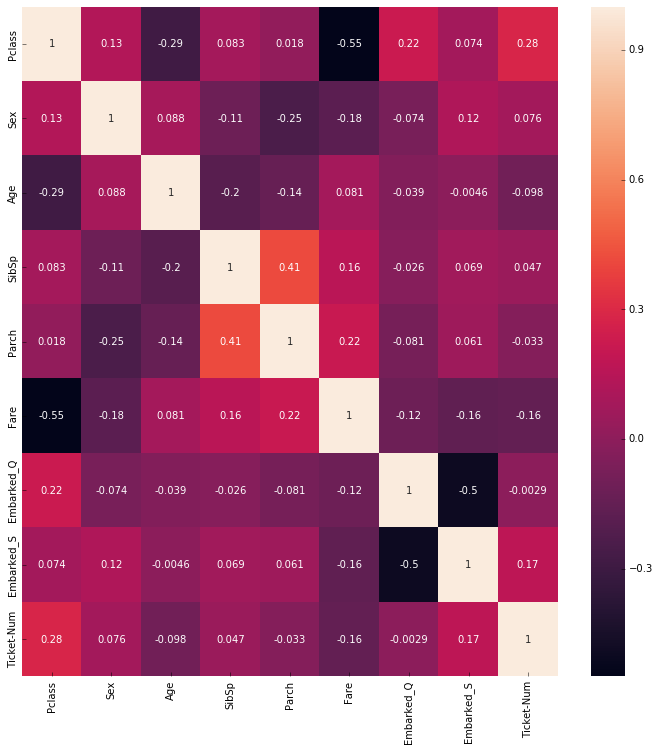

In [343]:
cols_to_correlate = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S', 'Ticket-Num'
                        ]#,' Mr', ' Mrs', ' Miss', ' Master', ' Ms']
%matplotlib inline

plt.figure(figsize=(12,12))
sbn.heatmap(X[cols_to_correlate].corr(), annot=True)

Accuracy 0.791044776119
AUC 0.773799374822
             precision    recall  f1-score   support

          0       0.77      0.90      0.83       153
          1       0.82      0.65      0.73       115

avg / total       0.80      0.79      0.79       268

confusion matrix:
[[137  16]
 [ 40  75]]


Feature Importances
Sex            0.177597
Ticket-Num     0.106408
Fare           0.098356
Age            0.097184
Pclass         0.050581
SibSp          0.024075
Parch          0.023972
Embarked_S     0.015257
Moor           0.006580
Andersson      0.005604
Jansson        0.005239
Embarked_Q     0.005118
Jussila        0.005052
Barah          0.004941
NULL-Ticket    0.004765
dtype: float64


Correlations
Sex           0.295231
Pclass        0.114569
Fare          0.066207
Embarked_S    0.022405
PC            0.021627
Ticket-Num    0.009140
Baclini       0.007239
Parch         0.006663
Richards      0.005423
Sage          0.004933
Age           0.004804
Panula        0.004223
CA           

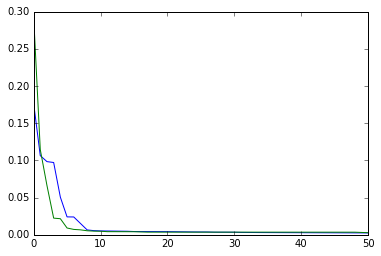

In [346]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.3,random_state=1)

clf = RandomForestClassifier()
clf.fit(X_train, Y_train)


predictions = clf.predict(X_val)
acc = metrics.accuracy_score(Y_val, predictions)
print('Accuracy', acc)
f1 = metrics.f1_score(Y_val, predictions)
auc = metrics.roc_auc_score(Y_val, predictions)
print('AUC', auc)
print(metrics.classification_report(Y_val, predictions))
conf = metrics.confusion_matrix(Y_val, predictions)
print('confusion matrix:')
print(conf)

feat_imp = pd.Series(clf.feature_importances_, X.columns).sort_values(ascending=False)
corrs = pd.Series(index=X.columns)
for i in X:
    corrs[i] = np.corrcoef(X[i],Y)[0,1]
    
corrs = corrs.apply(lambda x: x**2).sort_values(ascending=False)
   


plt.figure()
plt.plot(feat_imp.values)
plt.xlim(0,50)
plt.plot(corrs.values)

print('\n\nFeature Importances')
print(feat_imp[:15])

print('\n\nCorrelations')
print(corrs[:15])


In [347]:
important_features = list(feat_imp[:12].index)
X_train_cut = X_train[important_features]
X_val_cut = X_val[important_features]

clf.fit(X_train_cut, Y_train)


predictions = clf.predict(X_val_cut)
acc = metrics.accuracy_score(Y_val, predictions)
print('Accuracy', acc)
f1 = metrics.f1_score(Y_val, predictions)
auc = metrics.roc_auc_score(Y_val, predictions)
print('AUC', auc)
print(metrics.classification_report(Y_val, predictions))
conf = metrics.confusion_matrix(Y_val, predictions)
print('confusion matrix:')
print(conf)

Accuracy 0.820895522388
AUC 0.802102870134
             precision    recall  f1-score   support

          0       0.79      0.93      0.86       153
          1       0.89      0.67      0.76       115

avg / total       0.83      0.82      0.82       268

confusion matrix:
[[143  10]
 [ 38  77]]


In [348]:
parameters = {'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_leaf':[1, 0.05],
              'n_estimators':[50,100,200],
              'class_weight': ['balanced', 'balanced_subsample', None], 
              'criterion': ['gini', 'entropy']
             }
clf = RandomForestClassifier()
gs_cv = GridSearchCV(clf,parameters, cv=5, scoring='accuracy')
gs_cv.fit(X_train_cut, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 0.05], 'class_weight': ['balanced', 'balanced_subsample', None], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [349]:
print("The best parameter found on development set is :")
print(gs_cv.best_params_)
print("the best estimator is ")
print(gs_cv.best_estimator_)
print("The best score is ")
print(gs_cv.best_score_)

clf_best = gs_cv.best_estimator_
predictions = clf_best.predict(X_val_cut)
acc = metrics.accuracy_score(Y_val, predictions)
f1 = metrics.f1_score(Y_val, predictions)
auc = metrics.roc_auc_score(Y_val, predictions)
rec = metrics.recall_score(Y_val, predictions)
print('Accuracy', acc, 'F1', f1, 'AUC', auc, 'recall', rec)
print(metrics.confusion_matrix(Y_val, predictions))

The best parameter found on development set is :
{'min_samples_leaf': 1, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 50, 'max_features': 'sqrt'}
the best estimator is 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
The best score is 
0.84430176565
Accuracy 0.787313432836 F1 0.710659898477 AUC 0.765132139812 recall 0.608695652174
[[141  12]
 [ 45  70]]


             precision    recall  f1-score   support

          0       0.74      0.93      0.82       153
          1       0.86      0.57      0.68       115

avg / total       0.79      0.77      0.76       268

[[142  11]
 [ 50  65]]
Accuracy 0.772388059701


/Users/shaneyODB/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


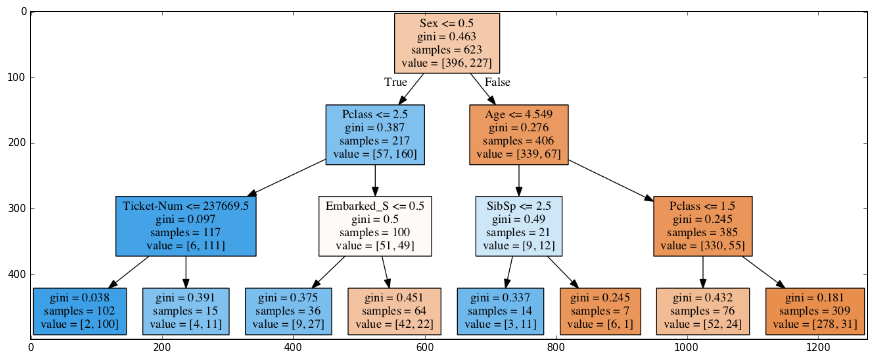

In [350]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from scipy import misc
from sklearn.tree import export_graphviz
import pydotplus

clf_1dt = DecisionTreeClassifier(max_depth=3)
clf_1dt.fit(X_train_cut, Y_train)

predictions = clf_1dt.predict(X_val_cut)

print(metrics.classification_report(Y_val, predictions))
print(metrics.confusion_matrix(Y_val, predictions))
print('Accuracy', metrics.accuracy_score(Y_val, predictions))

dot_file = StringIO()
export_graphviz(clf_1dt, out_file=dot_file, 
                feature_names=list(X_train_cut.columns), filled=True)

graph = pydotplus.graph_from_dot_data(dot_file.getvalue())
graph.create_png()
graph.write_png('test.png')
i = misc.imread('test.png')
plt.figure(figsize=(15,15))
plt.imshow(i)

## Summary

In [ ]:
'''
Of those that survived, many a)were not 'Mr.s', b) had high Pclass, and c) Had higher numbers

Of those that died, many a) were 'Mr.s', b) were of lower class, and c) were also male (surprise: must be a parsing error or mislabeling?)
'''